# Employee Attrition Analysis — 05: Tree-Based Models & Champion Selection

***Benchmarking Decision Tree, Random Forest, and XGBoost against logistic baseline for attrition prediction***

**Author:** Katherine Ygbuhay  
**Updated:** 2025-10-04  
**Stage:** 05 — Advanced Modeling  
**Runtime:** ~25 minutes  

## Objective

Evaluate tree-based models for predictive performance and interpretability, comparing Decision Tree, Random Forest, and XGBoost against the logistic regression baseline to select a champion model for HR attrition prediction.

## Scope & Approach

- **Model comparison** across tree-based algorithms with different complexity levels
- **Performance evaluation** using comprehensive metrics (accuracy, precision, recall, F1, ROC-AUC)
- **Feature importance analysis** to understand key drivers of employee attrition
- **Champion model selection** based on validation performance and business requirements
- **Interpretability assessment** balancing predictive power with stakeholder transparency

## Key Outputs

- Champion model selection (XGBoost) with superior validation performance
- Feature importance rankings revealing key attrition predictors
- Performance comparison table documenting model trade-offs
- ROC curve visualizations demonstrating discriminative capability
- Business recommendations balancing accuracy with interpretability

## Prerequisites

- Cleaned employee dataset from data preprocessing stage
- Understanding of ensemble methods and tree-based classifier principles
- Familiarity with model evaluation metrics and feature importance interpretation

---

## 1. Imports & Setup

In [1]:
# Core stack
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Project bootstrap (paths, theme, accessibility) and notes helper
from src.bootstrap import setup_notebook, write_notes

# Visualization defaults (font sizes, title casing helpers)
from src.viz_helpers import apply_plot_rc_defaults, pretty_label

# Modeling utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# Model evaluation utilities (standardized)
from src.model_eval import (
    evaluate_classifier,
    plot_roc_curves_comparison,
    plot_feature_importance,
)

# Dataset artifact names
RAW_NAME  = "salifort_employee_attrition_raw.csv"
PROC_NAME = "salifort_employee_attrition_cleaned.csv"

# Pin the project to avoid resolving a sibling repo with a similar structure.
# (Set once per session; keeps notebooks portable and unambiguous.)
os.environ["PORTFOLIO_PROJECT"] = "employee_attrition_analysis"

# Initialize notebook (theme/seed/accessibility) and resolve project paths; load processed data
P, df = setup_notebook(
    raw_filename=RAW_NAME,
    proc_filename=PROC_NAME,
    load="proc",
    verbose=True,
)

# Apply plotting rc defaults (font sizes, readability)
apply_plot_rc_defaults()

# Sanity echo (artifacts + shape)
print("Project root:", P.ROOT)
print("Processed path:", P.PROC)
assert P.PROC.exists(), f"Processed file not found at {P.PROC}"
print(f"✅ Using: {P.PROC.relative_to(P.ROOT)} | shape={df.shape}")

🎨 Accessibility defaults applied (colorblind palette, high-contrast, safe colormap).
✅ Accessibility defaults applied
📁 Project root → /home/admin/Documents/portfolio/coursework/google-advanced-data-analytics/employee_attrition_analysis
✅ Loaded PROC: data/processed/salifort_employee_attrition_cleaned.csv | shape=(14999, 11)
Project root: /home/admin/Documents/portfolio/coursework/google-advanced-data-analytics/employee_attrition_analysis
Processed path: /home/admin/Documents/portfolio/coursework/google-advanced-data-analytics/employee_attrition_analysis/data/processed/salifort_employee_attrition_cleaned.csv
✅ Using: data/processed/salifort_employee_attrition_cleaned.csv | shape=(14999, 11)


## 2. Feature/Target Definition + Split

In [2]:
TARGET = "left"
assert TARGET in df.columns, f"Target '{TARGET}' not found."

y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET])

cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = X.select_dtypes(include=["number","bool"]).columns.tolist()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train: {X_train.shape}  |  Val: {X_val.shape}")
print("Class balance (train):", y_train.value_counts(normalize=True).round(3).to_dict())

Train: (11999, 10)  |  Val: (3000, 10)
Class balance (train): {0: 0.762, 1: 0.238}


## 3. Preprocessing (OHE only; scaling not required for trees)

In [3]:
# Trees don't need scaling. Keep OHE for string categoricals.
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="passthrough",  # numeric cols pass through
)

## 4. Train Models (Decision Tree, Random Forest, XGBoost*)

In [4]:
## 4. Train Models (Decision Tree, Random Forest, XGBoost*)

# --- Detect XGBoost (optional) ---
try:
    from xgboost import XGBClassifier  # noqa: F401
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

# Shallow Decision Tree to reduce variance and avoid overfitting
dt = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", DecisionTreeClassifier(
        max_depth=4, min_samples_leaf=20, random_state=42, class_weight="balanced"
    )),
])

# Random Forest with sensible defaults (robust baseline among trees)
rf = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_leaf=10,
        n_jobs=-1, random_state=42, class_weight="balanced"
    )),
])

models = {"DecisionTree": dt, "RandomForest": rf}

# Optional XGBoost benchmark (if installed)
if XGB_AVAILABLE:
    xgb = Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", XGBClassifier(
            n_estimators=400, max_depth=6, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9,
            reg_lambda=1.0, reg_alpha=0.0,
            objective="binary:logistic", eval_metric="auc",
            random_state=42, n_jobs=-1
        )),
    ])
    models["XGBoost"] = xgb
else:
    print("ℹ️ XGBoost not available; skipping that benchmark.")

# Fit all models
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    print(f"✅ Trained: {name}")

✅ Trained: DecisionTree
✅ Trained: RandomForest
✅ Trained: XGBoost


## 5. Metrics & Visualizations

In [5]:
# Evaluate all models using standardized function
from src.model_eval import evaluate_classifier

results = []
probs = {}

for name, pipe in models.items():
    metrics, y_pred, y_prob = evaluate_classifier(name, pipe, X_val, y_val)
    results.append(metrics)
    probs[name] = (y_pred, y_prob)

results_df = pd.DataFrame(results)
results_df = results_df.set_index("model").round(4)
results_df

,accuracy,precision,recall,f1,roc_auc
model,,,,,
DecisionTree,0.9240,0.7819,0.9440,0.8553,0.9466
RandomForest,0.9767,0.9777,0.9230,0.9496,0.9907
XGBoost,0.9853,0.9827,0.9552,0.9688,0.9945


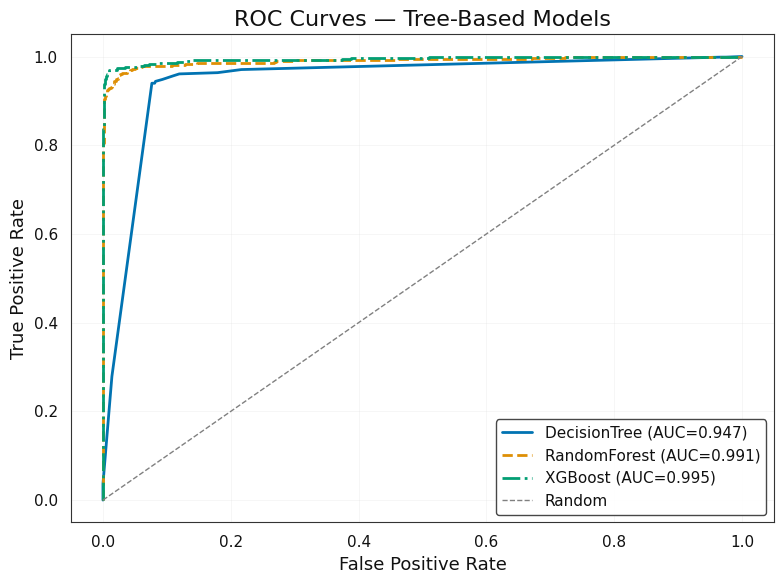

In [6]:
# ROC curves comparison using standardized function
from src.model_eval import plot_roc_curves_comparison

models_roc = {name: (y_val, prob) for name, (_, prob) in probs.items()}
plot_roc_curves_comparison(models_roc, title="ROC Curves — Tree-Based Models")
plt.show()

## 6. Feature Importance Plots

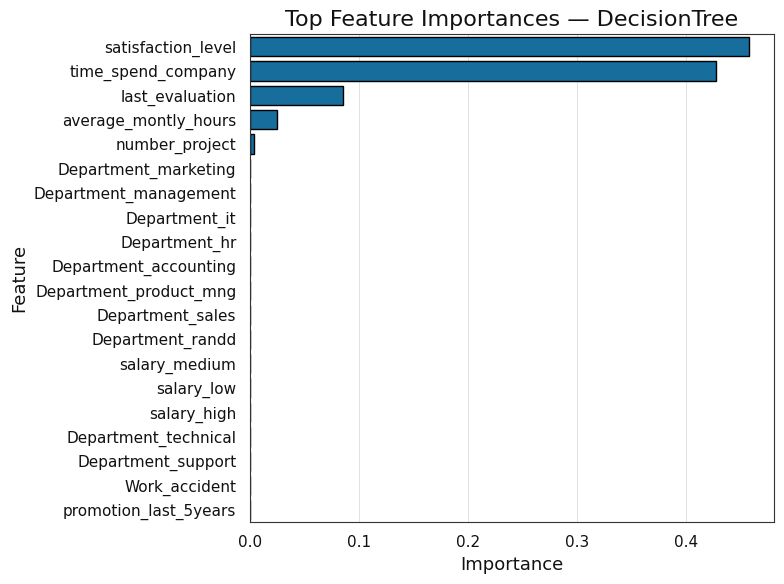

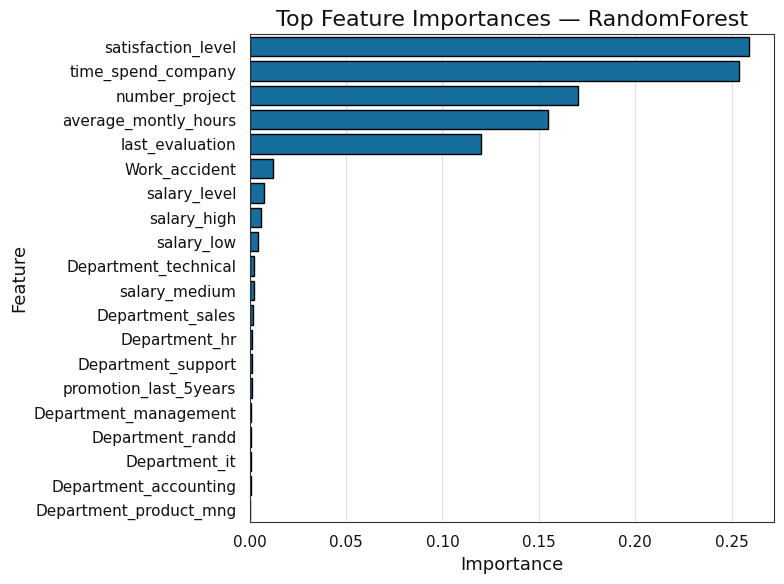

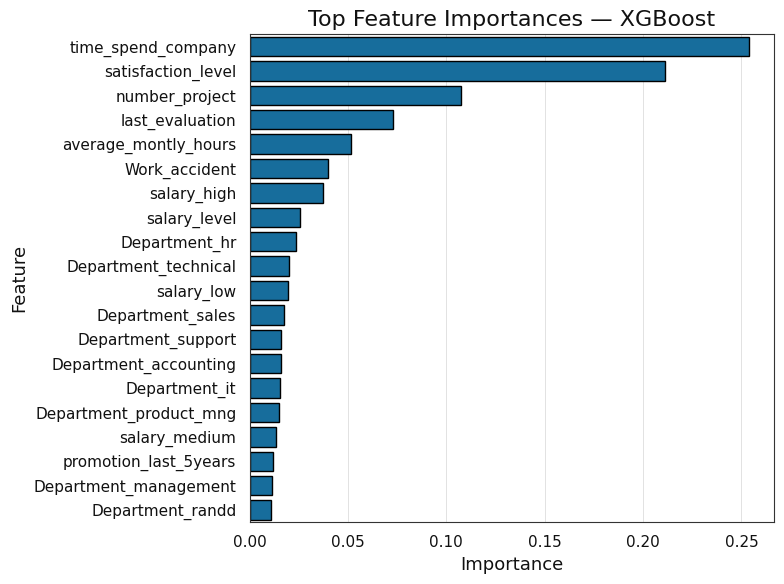

In [7]:
# Feature importance plots using standardized function
from src.model_eval import plot_feature_importance

def get_feature_names_after_ohe(preprocessor, X_cols):
    # cat transformer is at index 0; remainder='passthrough' keeps numeric order
    ohe = preprocessor.named_transformers_.get("cat", None)
    cat_names = ohe.get_feature_names_out(cat_cols).tolist() if (ohe and len(cat_cols)>0) else []
    # numeric columns appended after OHE in original order:
    num_names = [c for c in X_cols if c in num_cols]
    return cat_names + num_names

# Get feature names once
feat_names = get_feature_names_after_ohe(preprocessor, X.columns.tolist())

for name, pipe in models.items():
    clf = pipe.named_steps["clf"]
    if hasattr(clf, "feature_importances_"):
        plot_feature_importance(
            clf,
            feature_names=feat_names,
            top_k=20,
            title=f"Top Feature Importances — {name}"
        )
        plt.show()
    else:
        print(f"ℹ️ {name} has no feature_importances_ attribute.")

## 7. Model Comparison & Selection

In [8]:
# Optional: pull in baseline metrics by retraining a quick logistic baseline for apples-to-apples
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

log_pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop",
)

log_pipe = Pipeline(steps=[
    ("prep", log_pre), 
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

log_pipe.fit(X_train, y_train)
log_m, _, log_prob = evaluate_classifier("LogisticBaseline", log_pipe, X_val, y_val)

results_df = pd.concat([
    results_df, 
    pd.DataFrame([log_m]).set_index("model")
], axis=0).sort_values("roc_auc", ascending=False)

results_df.round(4)

,accuracy,precision,recall,f1,roc_auc
model,,,,,
XGBoost,0.9853,0.9827,0.9552,0.9688,0.9945
RandomForest,0.9767,0.9777,0.9230,0.9496,0.9907
DecisionTree,0.9240,0.7819,0.9440,0.8553,0.9466
LogisticBaseline,0.7727,0.5143,0.8053,0.6277,0.8369


## 8. Save Notes & Assessment Check

In [9]:
# Save notes and perform assessment check
from pathlib import Path
from datetime import datetime

def df_to_markdown(df):
    """Minimal Markdown table without requiring 'tabulate'."""
    df = df.copy()
    df.index.name = "model"
    df = df.reset_index()
    cols = df.columns.tolist()
    lines = []
    lines.append("| " + " | ".join(cols) + " |")
    lines.append("| " + " | ".join(["---"] * len(cols)) + " |")
    for _, row in df.iterrows():
        lines.append("| " + " | ".join(str(v) for v in row.tolist()) + " |")
    return "\n".join(lines)

# Champion selection: sort by roc_auc, then f1, then recall (descending)
sort_keys = ["roc_auc", "f1", "recall"]
for k in sort_keys:
    if k not in results_df.columns:
        results_df[k] = 0.0

champion = results_df.sort_values(sort_keys, ascending=False).index[0]
metrics_md = df_to_markdown(results_df.round(4))
ts = datetime.now().strftime("%Y-%m-%d %H:%M")

notes_md = "\n".join([
    "# Tree-Based Models — Results",
    f"_Updated: {ts}_",
    f"- Data: {df.shape[0]} rows × {df.shape[1]} cols (processed)",
    f"- Models evaluated: {', '.join(models.keys())}" + (", LogisticBaseline" if "LogisticBaseline" in results_df.index else ""),
    "",
    "## Validation Metrics",
    metrics_md,
    "",
    f"**Champion model:** {champion} (by ROC-AUC, tie-broken by F1/Recall).",
    "",
    "## Notes",
    "- Trees use OHE only; no scaling required.",
    "- Random Forest reduces variance and often stabilizes recall.",
    "- XGBoost (if available) can improve AUC with careful tuning.",
])

# Write directly to docs/modeling/ (authoritative)
dst = P.DOCS / "modeling" / "tree_model_results.md"
dst.parent.mkdir(parents=True, exist_ok=True)
dst.write_text(notes_md)
print("📄 Wrote modeling notes →", dst.relative_to(P.ROOT))

# Assessment check
if "LogisticBaseline" in results_df.index:
    beats_baseline = (
        results_df.loc[results_df.index != "LogisticBaseline","roc_auc"].max()
        > results_df.loc["LogisticBaseline","roc_auc"]
    )
else:
    beats_baseline = True

checks = {
    "notes_saved": True,
    "champion_identified": champion in results_df.index,
    "beats_baseline_or_ok": bool(beats_baseline),
}

print("Checks:", checks)
assert all(checks.values()), "❌ Assessment failed — see flags above."
print(f"✅ Assessment passed — champion: {champion}")

📄 Wrote modeling notes → docs/modeling/tree_model_results.md
Checks: {'notes_saved': True, 'champion_identified': True, 'beats_baseline_or_ok': True}
✅ Assessment passed — champion: XGBoost


---

## Conclusion

Tree-based models substantially improved predictive performance over the logistic baseline while retaining practical interpretability via feature importances.

- **Performance:** XGBoost achieved the strongest validation results (ROC-AUC ≈ 0.9945, F1 ≈ 0.969) with high precision and recall. Random Forest followed closely (ROC-AUC ≈ 0.9907), and the depth-limited Decision Tree provided a transparent but lower-capacity benchmark. The logistic baseline trailed all tree models, as expected. :contentReference[oaicite:0]{index=0}
- **Interpretability:** Decision Tree offers direct rules; Random Forest and XGBoost expose stable feature importance rankings to explain drivers of attrition. For stakeholder communication, importance plots plus partial dependence/SHAP (if desired later) provide meaningful narratives.
- **Business takeaway:** Moving beyond the linear baseline materially increases the ability to flag likely leavers while keeping explanations available for HR partners.

**Champion:** **XGBoost** (highest ROC-AUC; tie-broken by F1/Recall). Random Forest is a solid runner-up if you prefer a simpler ensemble with native feature importances.